## Looking at Detailed Stats
Beyond scores, we can try to use more detailed stats in our predictor.  We start by importing what we'll need.

In [237]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.utils import shuffle

%matplotlib inline

Now let's gather all NCAA tournament games we have detailed regular season stats (after 2002).

In [238]:
# Load in the data
game_results = pd.read_csv('Data/NCAATourneyCompactResults.csv')[['Season','WTeamID','LTeamID']]
team_seeds = pd.read_csv('Data/NCAATourneySeeds.csv')

game_results.head()

team_seeds.head()

# Convert seed to numeric value.
seed_to_int = lambda x: int(''.join([s for s in x if not s.isalpha()]))
team_seeds['Seed'] = team_seeds['Seed'].apply(seed_to_int)

team_seeds.head()

# Merge these into a single dataframe
win_seeds = team_seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
loss_seeds = team_seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})

merge_win = pd.merge(left=game_results,right=win_seeds,how='left',on=['Season','WTeamID'])
df = pd.merge(left=merge_win,right=loss_seeds,on=['Season','LTeamID'])
df['SeedDelta'] = df['WSeed'] - df['LSeed']

df = df[df['Season']>=2003].reset_index(drop=True)
df.tail()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDelta
976,2017,1314,1246,1,2,-1
977,2017,1376,1196,7,4,3
978,2017,1211,1376,1,7,-6
979,2017,1314,1332,1,3,-2
980,2017,1314,1211,1,1,0


Ok, we can simplify this dataframe by combining season and teamID.  We'll build this dataframe up by adding in stats, and use it to test/train our regression model.

In [239]:
df_tourney = pd.DataFrame()
df_tourney['Team'] = df['Season'].map(str)+'_'+df['WTeamID'].map(str)
df_tourney['OppTeam'] = df['Season'].map(str)+'_'+df['LTeamID'].map(str)
df_tourney=df_tourney.rename(columns={'OppTeam':'Opponent'})

df_tourney.tail()

,Team,Opponent
976,2017_1314,2017_1246
977,2017_1376,2017_1196
978,2017_1211,2017_1376
979,2017_1314,2017_1332
980,2017_1314,2017_1211


Ok let's now read in regular season detailed stats to a dataframe.

In [240]:
full_df = pd.read_csv('Data/RegularSeasonDetailedResults.csv')
win_stats = full_df[[col for col in full_df if col.startswith('W') and col!='WTeamID' and col!='WLoc']]
win_stats = win_stats.rename(columns=lambda x: x.replace('W', '')) #rename without 'W'

lose_stats = full_df[[col for col in full_df if col.startswith('L') and col!='LTeamID']]
lose_stats = lose_stats.rename(columns=lambda x: x.replace('L', '')) #rename without 'L'

stats_df = pd.concat([win_stats,lose_stats])
stats_df.head()

,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,68,27,58,3,14,11,18,14,24,13,23,7,1,22
1,70,26,62,8,20,10,19,15,28,16,13,4,4,18
2,73,24,58,8,18,17,29,17,26,15,10,5,2,25
3,56,18,38,3,9,17,31,6,19,11,12,14,2,18
4,77,30,61,6,14,11,13,17,22,12,14,4,4,20


Ok, we have 14 different stats we can use.  Some of these are likely much better predictors of a win/loss than others.  Let's check the mutual information to determine the most useful stats to use.

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:608: RuntimeWarning: invalid value encountered in log
  log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())


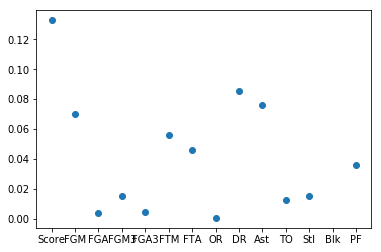

In [241]:
stats = stats_df.values
ngames = int(np.size(stats,0)/2)

result = np.zeros(2*ngames)
result[:ngames] = 1

#calculate mutual information b/w stats and result
MI=sklearn.feature_selection.mutual_info_classif(stats_df.values,result,discrete_features=True)
fig,ax=plt.subplots()
ax.plot(MI,'o')
ax.set_xticks(np.arange(14))
ax.set_xticklabels(list(stats_df.columns))
print('')

As expected score is the best predictor.  Another good predictor appears to be defensive rebounds.  Lets try building a logistic regression with a few of these detailed stats included.  We again use the For vs Against and Against vs For format, as in 'NCAA Exploratory Analysis' notebook.

In [242]:
#read in data
reg_season = pd.read_csv('Data/RegularSeasonDetailedResults.csv')
reg_season = reg_season[['Season','WTeamID','LTeamID','WScore','LScore','WFGM','LFGM','WFTM','LFTM','WDR','LDR','WAst','LAst']]

win_stats = reg_season.rename(columns={'WTeamID':'Team','LTeamID':'OppTeam',
                                        'WScore':'Score For','LScore':'Score Against',
                                        'WFGM':'FGM For','LFGM':'FGM Against',
                                        'WFTM':'FTM For','LFTM':'FTM Against',
                                        'WDR':'DR For','LDR':'DR Against',
                                        'WAst':'Ast For','LAst':'Ast Against'})
win_stats['Result'] = 1
lose_stats = reg_season.rename(columns={'LTeamID':'Team','WTeamID':'OppTeam',
                                         'LScore':'Score For','WScore':'Score Against',
                                         'LFGM':'FGM For','WFGM':'FGM Against',
                                         'LFTM':'FTM For','WFTM':'FTM Against',
                                         'LDR':'DR For','WDR':'DR Against',
                                         'LAst':'Ast For','WAst':'Ast Against'})
lose_stats['Result'] = 0

#combine wins and losses
reg_stats = pd.concat([win_stats,lose_stats])

#rename team identifier to include season
reg_stats['Team'] = reg_stats['Season'].map(str)+'_'+reg_stats['Team'].map(str)
reg_stats['OppTeam'] = reg_stats['Season'].map(str)+'_'+reg_stats['OppTeam'].map(str)
reg_stats=reg_stats.drop('Season',axis=1)

reg_stats.tail()

,Ast Against,Ast For,DR Against,DR For,FGM Against,FGM For,FTM Against,FTM For,OppTeam,Result,Score Against,Score For,Team
76631,17,10,22,18,27,22,7,6,2017_1276,0,71,56,2017_1458
76632,15,12,23,20,25,20,10,13,2017_1343,0,71,59,2017_1463
76633,12,8,27,24,24,21,14,17,2017_1348,0,70,63,2017_1433
76634,14,7,27,22,26,19,9,14,2017_1374,0,71,56,2017_1153
76635,5,10,19,27,21,20,16,7,2017_1407,0,59,53,2017_1402


Now we get all the mean stats from over the regular season.

In [243]:
mean_stats=reg_stats.groupby('Team').mean().reset_index()
mean_stats=mean_stats.drop('Result',axis=1)
mean_stats.tail()

,Team,Ast Against,Ast For,DR Against,DR For,FGM Against,FGM For,FTM Against,FTM For,Score Against,Score For
5125,2017_1460,12.300000,14.633333,24.366667,24.833333,25.733333,25.266667,15.033333,16.433333,74.300000,75.700000
5126,2017_1461,11.733333,14.733333,28.866667,29.400000,25.633333,25.466667,18.833333,17.033333,76.900000,77.466667
5127,2017_1462,14.058824,14.852941,22.500000,25.382353,25.352941,25.764706,13.205882,16.058824,71.352941,74.617647
5128,2017_1463,13.428571,15.250000,22.821429,25.750000,25.857143,26.035714,11.392857,14.107143,70.785714,73.178571
5129,2017_1464,16.343750,14.656250,29.281250,25.750000,30.781250,28.625000,13.656250,11.468750,83.187500,76.000000


Ok now let's add on all of our mean stats For vs Against onto this dataframe.

In [244]:
def findOD(row,stat_type):
    team_m_stats = mean_stats[mean_stats['Team']==row['Team']]
    opp_m_stats = mean_stats[mean_stats['Team']==row['Opponent']]
    
    XvsY = team_m_stats[stat_type+' For'].values + opp_m_stats[stat_type+' Against'].values
    YvsX = team_m_stats[stat_type+' Against'].values + opp_m_stats[stat_type+' For'].values
    
    row[stat_type+' For Vs Against'] = XvsY[0]
    row[stat_type+' Against Vs For'] = YvsX[0]
    return row

df_tourney=df_tourney.apply(findOD,axis=1,args=('Score',))
df_tourney=df_tourney.apply(findOD,axis=1,args=('FGM',))
df_tourney=df_tourney.apply(findOD,axis=1,args=('FTM',))
df_tourney=df_tourney.apply(findOD,axis=1,args=('DR',))
df_tourney=df_tourney.apply(findOD,axis=1,args=('Ast',))

df_tourney['Seed Difference'] = df['SeedDelta']
df_tourney.tail()

,Team,Opponent,Score For Vs Against,Score Against Vs For,FGM For Vs Against,FGM Against Vs For,FTM For Vs Against,FTM Against Vs For,DR For Vs Against,DR Against Vs For,Ast For Vs Against,Ast Against Vs For,Seed Difference
976,2017_1314,2017_1246,155.921569,156.850267,56.524955,54.934046,29.540998,31.923351,51.926025,49.376114,29.241533,27.226381,-1
977,2017_1376,2017_1196,138.046371,142.829637,47.820565,47.529234,30.166331,34.763105,48.202621,50.394153,21.981855,22.012097,3
978,2017_1211,2017_1376,149.124145,132.635386,51.299120,46.712610,33.964809,26.746823,55.552297,45.483871,25.417400,22.055718,-6
979,2017_1314,2017_1332,149.696970,149.575758,54.545455,52.727273,26.575758,27.515152,49.272727,47.424242,29.727273,28.030303,-2
980,2017_1314,2017_1211,145.484848,155.484848,53.303030,55.121212,25.818182,29.939394,49.484848,52.727273,27.848485,27.727273,0


We add on both data when the first team is the winner and when the first team is the loser.

In [245]:
wins = df_tourney
wins=wins.drop('Team',axis=1)
wins=wins.drop('Opponent',axis=1)
wins['Result'] = 1

loss = pd.DataFrame()
loss['Seed Difference'] = -df_tourney['Seed Difference']
loss['Score For Vs Against'] = df_tourney['Score Against Vs For']
loss['Score Against Vs For'] = df_tourney['Score For Vs Against']
loss['FGM For Vs Against'] = df_tourney['FGM Against Vs For']
loss['FGM Against Vs For'] = df_tourney['FGM For Vs Against']
loss['FTM For Vs Against'] = df_tourney['FTM Against Vs For']
loss['FTM Against Vs For'] = df_tourney['FTM For Vs Against']
loss['DR For Vs Against'] = df_tourney['DR Against Vs For']
loss['DR Against Vs For'] = df_tourney['DR For Vs Against']
loss['Ast For Vs Against'] = df_tourney['Ast Against Vs For']
loss['Ast Against Vs For'] = df_tourney['Ast For Vs Against']
loss['Result'] = 0

data = pd.concat([wins,loss])
data['Season'] = df['Season']

data.tail()

,Ast Against Vs For,Ast For Vs Against,DR Against Vs For,DR For Vs Against,FGM Against Vs For,FGM For Vs Against,FTM Against Vs For,FTM For Vs Against,Result,Score Against Vs For,Score For Vs Against,Seed Difference,Season
976,29.241533,27.226381,51.926025,49.376114,56.524955,54.934046,29.540998,31.923351,0,155.921569,156.850267,1,2017
977,21.981855,22.012097,48.202621,50.394153,47.820565,47.529234,30.166331,34.763105,0,138.046371,142.829637,-3,2017
978,25.417400,22.055718,55.552297,45.483871,51.299120,46.712610,33.964809,26.746823,0,149.124145,132.635386,6,2017
979,29.727273,28.030303,49.272727,47.424242,54.545455,52.727273,26.575758,27.515152,0,149.696970,149.575758,2,2017
980,27.848485,27.727273,49.484848,52.727273,53.303030,55.121212,25.818182,29.939394,0,145.484848,155.484848,0,2017


Great, now let's split this up into training and test data and build our regression.

In [246]:
#split up into train and test data
train_data = data[data['Season']<2014].drop(['Season'],axis=1)
test_data = data[data['Season']>=2014].drop(['Season'],axis=1)

train_data = train_data.reindex_axis(sorted(train_data.columns), axis=1)
test_data = test_data.reindex_axis(sorted(test_data.columns), axis=1)

#split up into features and ground truth (all features)
x_train = train_data.drop('Result',axis=1).values
y_train = train_data['Result']
x_train,y_train = shuffle(x_train,y_train)

#create classifier and train (all features)
logistic_reg = LogisticRegression(C=1000) #C is inverse of regularization strength
logistic_reg.fit(x_train,y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We should also do a parameter search on C to find the optimal value as judged via cross-validation.

In [247]:
from sklearn.model_selection import GridSearchCV
params = {'C': np.logspace(start=-3, stop=-2, num=50)}

logistic_reg = GridSearchCV(LogisticRegression(), params, scoring='neg_log_loss', refit=True)
logistic_reg.fit(x_train,y_train)

print('Best log_loss: {:.4}, with best C: {}'.format(logistic_reg.best_score_, logistic_reg.best_params_['C']))

Best log_loss: -0.5433, with best C: 0.0015998587196060573


Let's check our resulting log loss.

In [248]:
#get feature data to predict on
X = test_data.drop('Result',axis=1)
X = X.reindex_axis(sorted(X.columns), axis=1).values

#make predictions
p=logistic_reg.predict_proba(X)

#gather ground truth
gt = np.zeros_like(p)
gt[:,1]=test_data['Result'].values
gt[:,0] = 1 - gt[:,1]

#compare log loss
logloss = sklearn.metrics.log_loss(gt,p)

print('All Features Log Loss is %1.4f'%logloss)

All Features Log Loss is 0.5546


## Create Submission.

It appears that including the detailed stats gives an improvement.  Lets save a submission with this model.

In [249]:
def addTeamIDs(row):
    teamIDs = row['ID'].split('_')
    
    row['Team'] = teamIDs[0]+'_'+teamIDs[1]
    row['Opponent'] = teamIDs[0]+'_'+teamIDs[2]
    
    return row

df_sample = pd.read_csv('Data/SampleSubmissionStage1.csv')

df_sample = df_sample.apply(addTeamIDs,axis=1)
df_sample = df_sample.drop('ID',axis=1)
df_sample.head()

,Pred,Team,Opponent
0,0.5,2014_1107,2014_1110
1,0.5,2014_1107,2014_1112
2,0.5,2014_1107,2014_1113
3,0.5,2014_1107,2014_1124
4,0.5,2014_1107,2014_1140


In [250]:
team_seeds = pd.read_csv('Data/NCAATourneySeeds.csv')

seed_to_int = lambda x: int(''.join([s for s in x if not s.isalpha()]))
team_seeds['Seed'] = team_seeds['Seed'].apply(seed_to_int)

team_seeds['Team'] = team_seeds['Season'].map(str)+'_'+team_seeds['TeamID'].map(str)
team_seeds = team_seeds.drop('TeamID',1).drop('Season',1)
team_seeds.head()

,Seed,Team
0,1,1985_1207
1,2,1985_1210
2,3,1985_1228
3,4,1985_1260
4,5,1985_1374


In [251]:
def findSeedDiff(row):
    teamId = row['Team']
    oppId = row['Opponent']
    
    teamSeed = team_seeds[team_seeds['Team']==teamId]['Seed'].values[0]
    oppSeed = team_seeds[team_seeds['Team']==oppId]['Seed'].values[0]
    row['Seed Difference'] = teamSeed - oppSeed
    return row

df_sample=df_sample.apply(findSeedDiff,1)
df_sample.head()

,Pred,Team,Opponent,Seed Difference
0,0.5,2014_1107,2014_1110,1
1,0.5,2014_1107,2014_1112,15
2,0.5,2014_1107,2014_1113,6
3,0.5,2014_1107,2014_1124,10
4,0.5,2014_1107,2014_1140,6


In [252]:
df_sample = df_sample.apply(findOD,axis=1,args=('Score',))
df_sample = df_sample.apply(findOD,axis=1,args=('FGM',))
df_sample = df_sample.apply(findOD,axis=1,args=('FTM',))
df_sample = df_sample.apply(findOD,axis=1,args=('DR',))
df_sample = df_sample.apply(findOD,axis=1,args=('Ast',))
df_sample.head()

,Pred,Team,Opponent,Seed Difference,Score For Vs Against,Score Against Vs For,FGM For Vs Against,FGM Against Vs For,FTM For Vs Against,FTM Against Vs For,DR For Vs Against,DR Against Vs For,Ast For Vs Against,Ast Against Vs For
0,0.5,2014_1107,2014_1110,1,124.656250,127.781250,42.593750,45.781250,29.843750,22.968750,43.531250,44.531250,21.156250,27.468750
1,0.5,2014_1107,2014_1112,15,124.178309,136.902574,42.819853,48.985294,29.220588,26.731618,45.424632,47.887868,20.238971,27.431985
2,0.5,2014_1107,2014_1113,6,134.906250,138.875000,47.125000,48.031250,30.437500,27.781250,50.656250,48.781250,22.625000,26.531250
3,0.5,2014_1107,2014_1124,10,134.425189,137.631629,46.922348,47.750000,28.886364,27.831439,44.582386,45.654356,26.395833,26.858902
4,0.5,2014_1107,2014_1140,6,143.576705,148.055871,49.437500,52.022727,32.280303,31.922348,48.885417,49.381629,25.638258,27.980114


Now that we have our table of stats, we can use our model and save our predictions.

In [253]:
#use our regression to predict winning probability
X = df_sample.drop(['Pred','Team','Opponent'],axis=1)
X = X.reindex_axis(sorted(X.columns), axis=1).values #make sure columns are in correct order
preds=logistic_reg.predict_proba(X)[:,1]

#clip and display
clipped_preds = np.clip(preds, 0.01, 0.99)
df_sample['Pred'] = clipped_preds
df_sample.head()

,Pred,Team,Opponent,Seed Difference,Score For Vs Against,Score Against Vs For,FGM For Vs Against,FGM Against Vs For,FTM For Vs Against,FTM Against Vs For,DR For Vs Against,DR Against Vs For,Ast For Vs Against,Ast Against Vs For
0,0.416839,2014_1107,2014_1110,1,124.656250,127.781250,42.593750,45.781250,29.843750,22.968750,43.531250,44.531250,21.156250,27.468750
1,0.053315,2014_1107,2014_1112,15,124.178309,136.902574,42.819853,48.985294,29.220588,26.731618,45.424632,47.887868,20.238971,27.431985
2,0.258782,2014_1107,2014_1113,6,134.906250,138.875000,47.125000,48.031250,30.437500,27.781250,50.656250,48.781250,22.625000,26.531250
3,0.181629,2014_1107,2014_1124,10,134.425189,137.631629,46.922348,47.750000,28.886364,27.831439,44.582386,45.654356,26.395833,26.858902
4,0.242888,2014_1107,2014_1140,6,143.576705,148.055871,49.437500,52.022727,32.280303,31.922348,48.885417,49.381629,25.638258,27.980114


In [254]:
#save the results to a csv
df_out = pd.read_csv('Data/SampleSubmissionStage1.csv')

df_out['Pred'] = df_sample['Pred']
df_out.to_csv('logreg_seed_pts.csv', index=False)